In [1]:
import sys
import warnings
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score

% matplotlib inline

plt.style.use('ggplot')

In [2]:
#
# Load logins into a dataframe.
#
login_df = pd.read_json('logins.json')
login_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
#
# Print the info.
#
login_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
#
# Print the description.
#
login_df.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


# Part One - Exploratory Data Analysis

Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [5]:
#
# Set the login time as data index and sort.
#
login_df = login_df.set_index('login_time').sort_index()
login_df['count'] = 1
login_df.head(10)

,count
login_time,
1970-01-01 20:12:16,1
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:36,1
1970-01-01 20:16:37,1
1970-01-01 20:21:41,1
1970-01-01 20:26:05,1
1970-01-01 20:26:21,1
1970-01-01 20:31:03,1


In [6]:
#
# Resampling the data based on a 15 min window.
#
min15_df = login_df.resample('15T').count()
min15_df.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


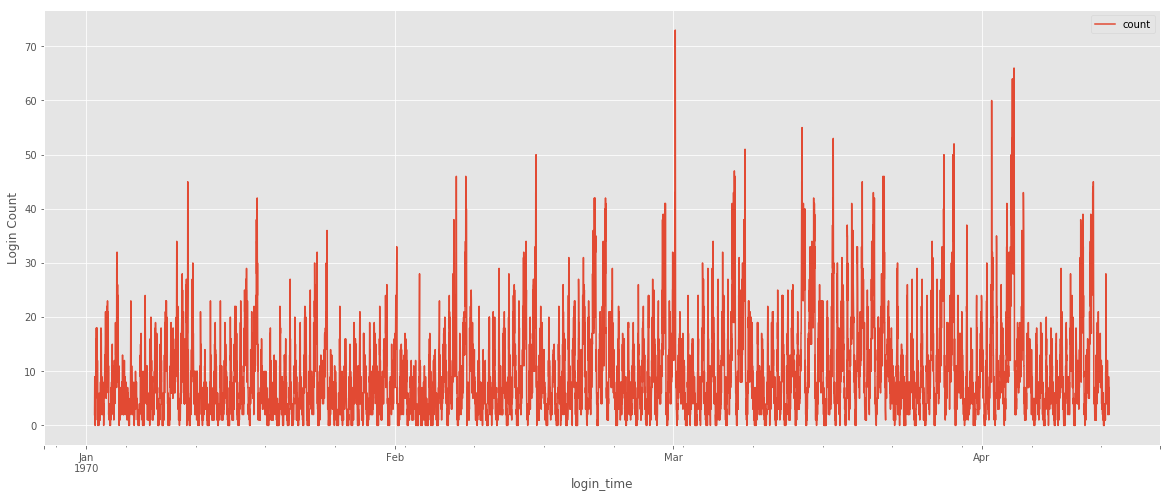

In [7]:
#
# Visualizing the trend of login count aggregated in 15 min buckets.
#
min15_df.plot(figsize=(20,8))
plt.ylabel("Login Count")
plt.show()

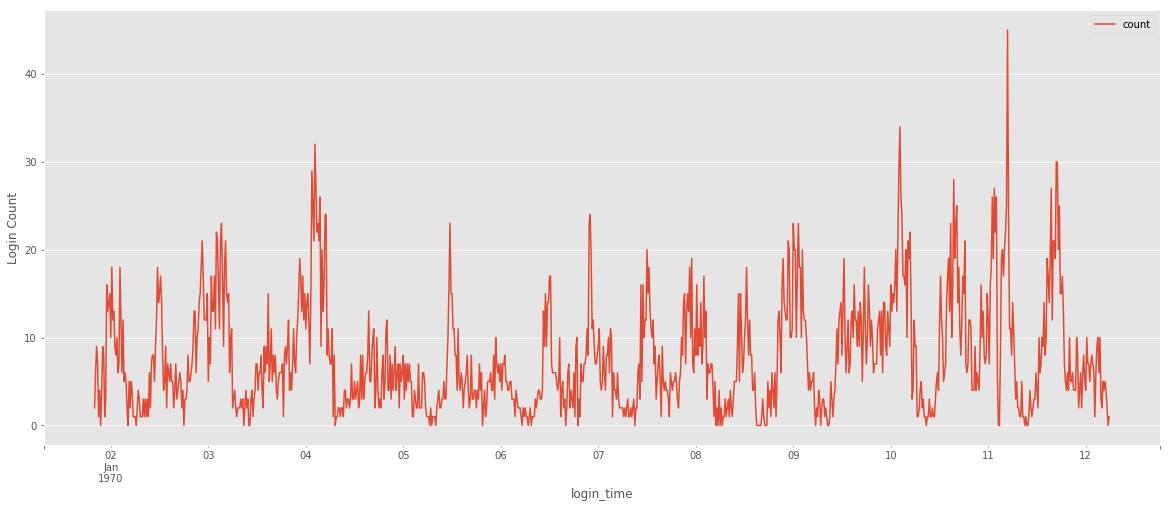

In [8]:
#
# Zoom in on the first part of the plot to better understand the trend.
#
min15_df[0:1000].plot(figsize=(20,8))
plt.ylabel("Login Count")
plt.show()

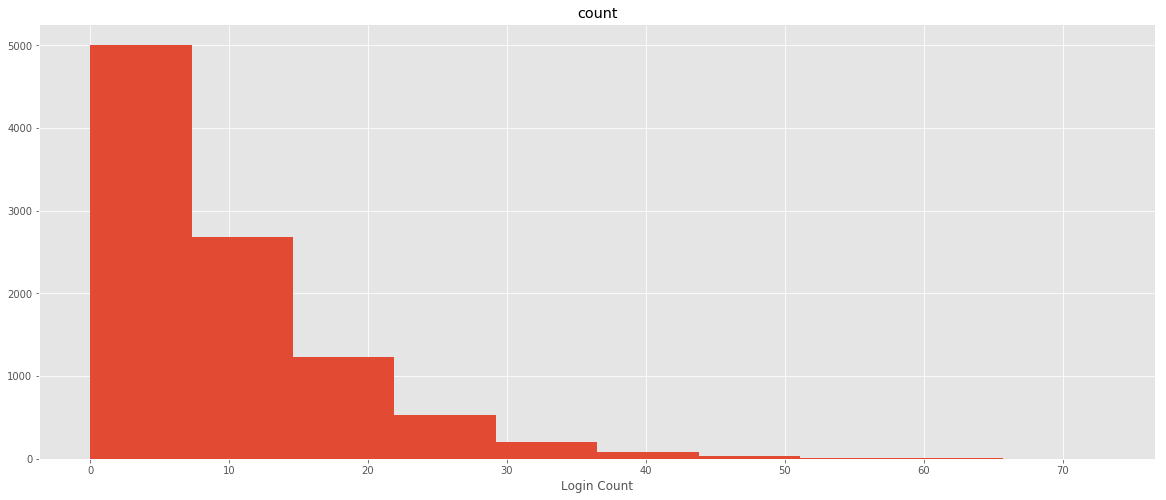

In [9]:
#
# Plot the histogram of login count.
#
min15_df.hist(figsize=(20,8))
plt.xlabel("Login Count")
plt.show()

### There appears to be periodicity but its hard to tell at what scale. Lets example the days of the week.

In [10]:
#
# Map to day of week.
#
dayOfWeek = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
min15_df['daynum'] = min15_df.index.weekday
min15_df['dayOfWeek'] = min15_df['daynum'].map(dayOfWeek)
min15_df.head()

,count,daynum,dayOfWeek
login_time,,,
1970-01-01 20:00:00,2,3,Thu
1970-01-01 20:15:00,6,3,Thu
1970-01-01 20:30:00,9,3,Thu
1970-01-01 20:45:00,7,3,Thu
1970-01-01 21:00:00,1,3,Thu


In [11]:
#
# Store the day of week and number.
#
days = ['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun']
min15_df['dayOfWeek'] = pd.Categorical(min15_df['dayOfWeek'], categories=days, ordered=True)

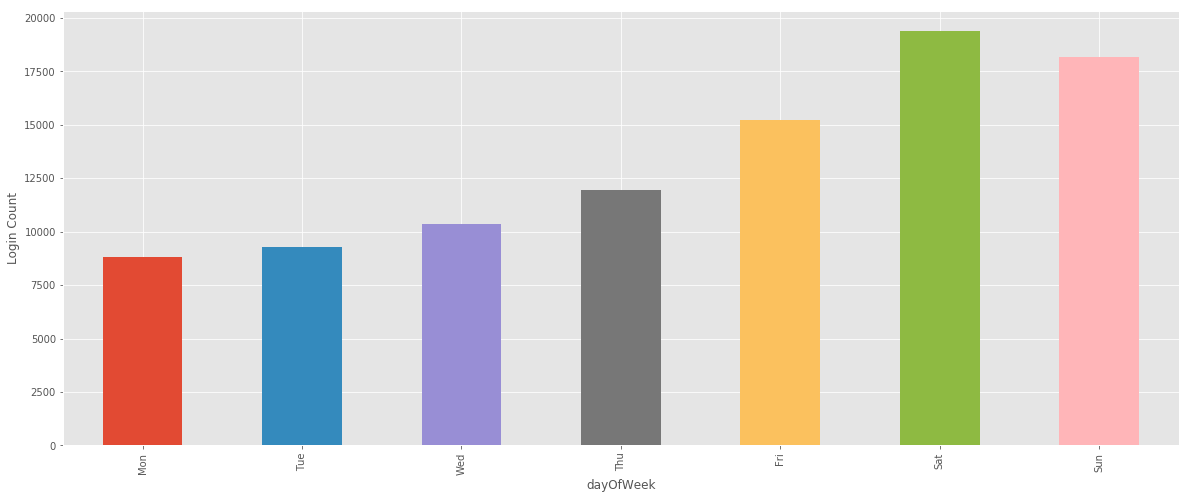

In [12]:
#
# Plot the aggregate by day of week. 
#
weekday_counts = min15_df.groupby('dayOfWeek')['count'].aggregate(sum)
weekday_counts.plot(kind='bar', figsize=(20,8))
plt.ylabel('Login Count')
plt.show()

### It appears logins grow day over day until they reach their peak on Saturday.

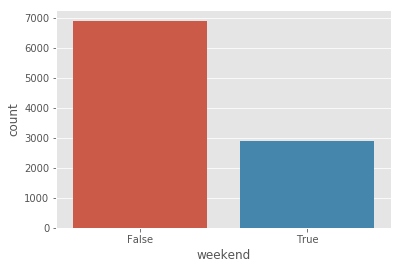

In [13]:
#
# Weekend split.
#
min15_df['weekend'] = min15_df['dayOfWeek'].isin(['Sat', 'Sun'])
sns.countplot(x='weekend', data=min15_df)

In [14]:
#
# Map to hour of day.
#
min15_df['hour'] = min15_df.index.hour
min15_df.head()

,count,daynum,dayOfWeek,weekend,hour
login_time,,,,,
1970-01-01 20:00:00,2,3,Thu,False,20
1970-01-01 20:15:00,6,3,Thu,False,20
1970-01-01 20:30:00,9,3,Thu,False,20
1970-01-01 20:45:00,7,3,Thu,False,20
1970-01-01 21:00:00,1,3,Thu,False,21


Text(0,0.5,'Login Count')

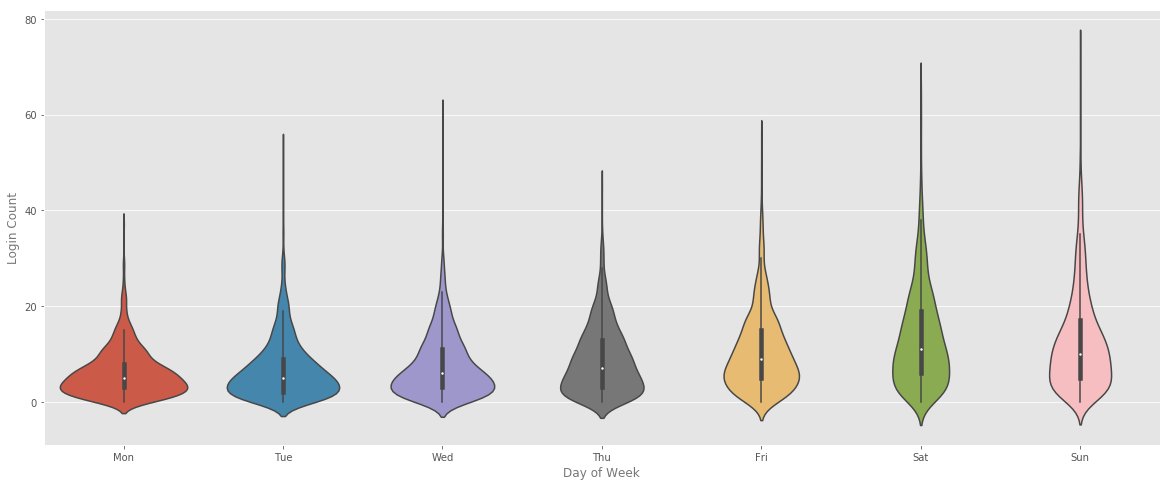

In [15]:
#
# Distribution of count using a violin plot.
#
f, (ax) = plt.subplots(1, 1, figsize=(20, 8))

sns.violinplot(x="dayOfWeek", y='count', data=min15_df,  ax=ax)
ax.set_xlabel("Day of Week",size = 12,alpha=0.8)
ax.set_ylabel("Login Count",size = 12,alpha=0.8)

Text(0,0.5,'Login Hour')

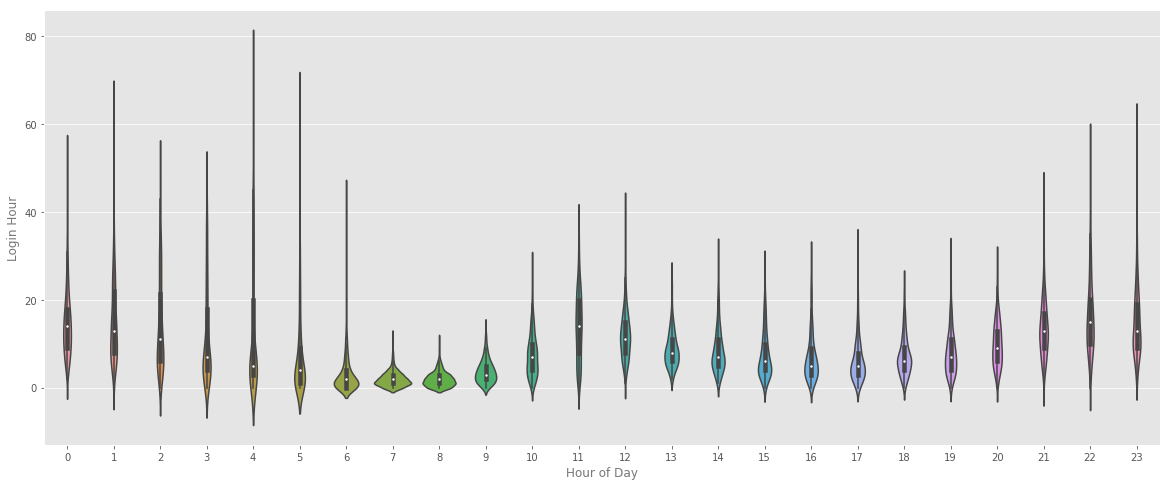

In [16]:
#
# Distribution of hour using a violin plot.
#
f, (ax) = plt.subplots(1, 1, figsize=(20, 8))

sns.violinplot(x="hour", y='count', data=min15_df,  ax=ax)
ax.set_xlabel("Hour of Day",size = 12,alpha=0.8)
ax.set_ylabel("Login Hour",size = 12,alpha=0.8)

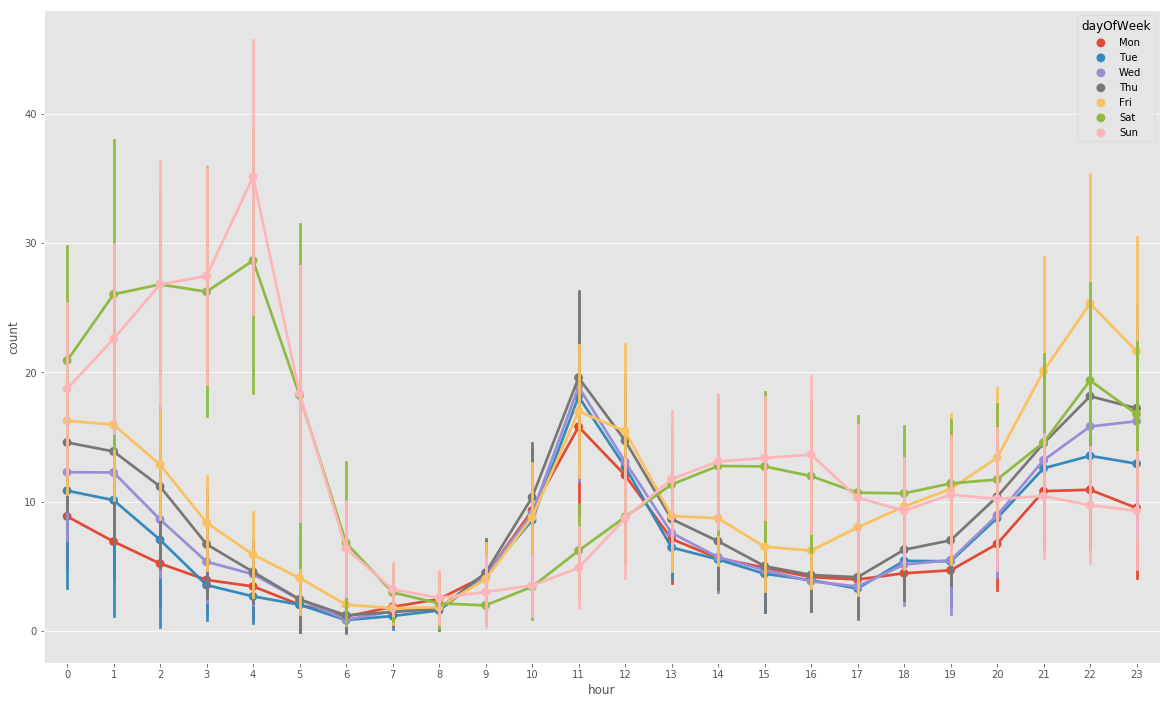

In [17]:
#
# Plot mean login count by day.
#
sns.pointplot(x='hour', y='count', hue='dayOfWeek', data=min15_df, ci="sd")
plt.gcf().set_size_inches(20,12)
plt.show()

## Conclusion

Activity appears to build over the course of the week, peaking on Saturday. Weeks days peak around lunch and after work. Weekends peak in the early morning.

The only data quality issue discovered was that the login times were not in chronological order.

## Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a. how you will implement the experiment

b. what statistical test(s) you will conduct to verify the significance of the
observation

c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.



## Responses

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

> The key measure of success would be the mean active time spent in the other city while the experiment is underway vs the mean active time spent in the other city prior to the experiment.  This metric was chosen because its really the only metric that makes sense in this case.  This is the dependent variable that we are trying to impact through this proposed experiement. 


2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a. how you will implement the experiment:
    
> Data would be collected for at least a month (if it hasnt already) to establish a baseline of driver activity.  The drivers would then be told about the updated terms regarding toll reimbursement.  The experiemnt would then be carried out for at least a month to gather enough data to allow for statistical formulas to be confidently applied. 

b. what statistical test(s) you will conduct to verify the significance of the
observation

> Assuming that more than 30 drivers are being observed, a positive single tailed z test would be performed. We really only care about positive effects to the activity in the other city so any negative effects would not skew results. 

c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

>  A p-value of 0.05 or less would need to be acheived in order to reject the null hypothesis that: There is no effect of paying for toll on drivers activity in the other city.  The caveats are:
- It is assumed that only the toll change is responsible for drivers activity changes.
- It is not known if the drivers move addresses and therefore naturally start to drive in the other city more.
- Weekend vs week day may play a role here and should be looked at carefully.

## Part 3 - Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).


### Data description
- city: city this user signed up in
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYYMMDD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
- avg_dist: the average distance in miles per trip taken in the first 30 days after signup
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
- ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday



In [18]:
#
# Read in the JSON.
#
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)

#
# Convert the data to a pandas dataframe.
#
df = pd.DataFrame(data)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


> Several columns appear to be missing data

In [20]:
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [21]:
#
# Convert the dates to datetime.
#
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

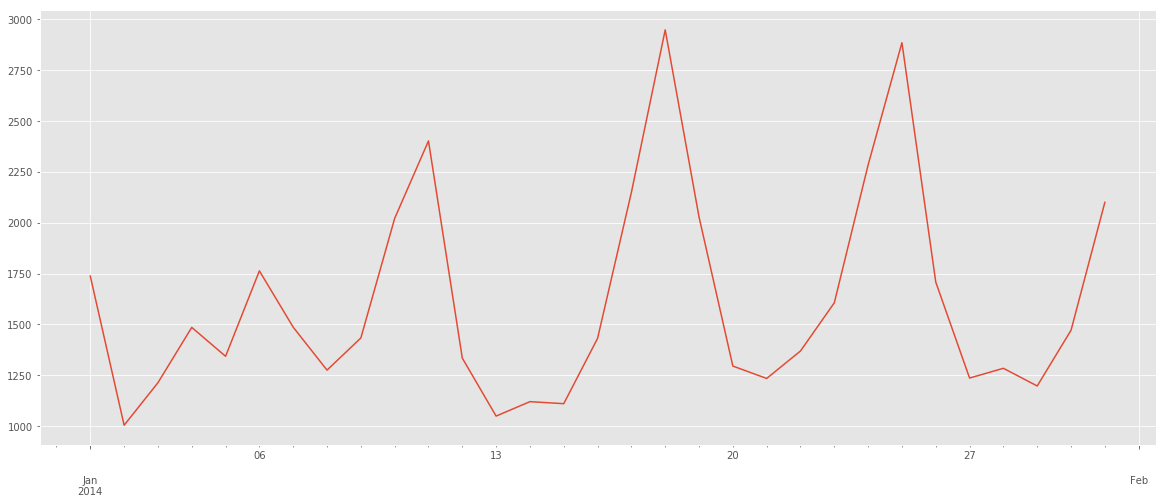

In [22]:
#
# Visualze sign up.
#
df.groupby('signup_date').size().plot(figsize = (20,8))
plt.xlabel('')
plt.show()

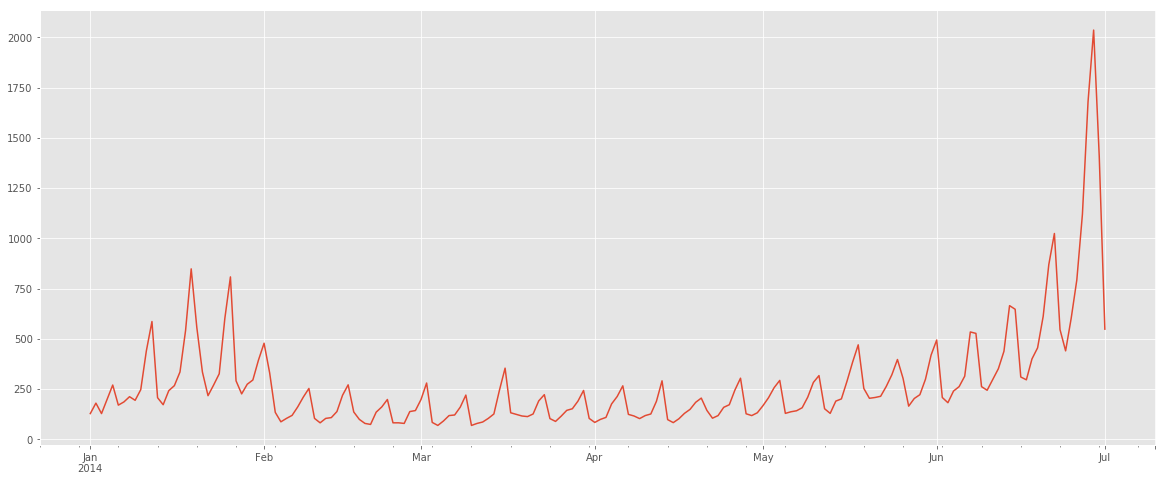

In [23]:
#
# Visualze last trip date.
#
df.groupby('last_trip_date').size().plot(figsize = (20,8))
plt.xlabel('')
plt.show()

In [24]:
#
# Obtain active status.
#
active_users = []
for i in range(len(df)):
    start = pd.Timestamp(df['signup_date'][i])
    end = start + pd.Timedelta('181D')
    window = end - pd.Timedelta('30D')
    if window <= pd.Timestamp(df['last_trip_date'][i]) <= end:
        active_users.append(1)
    else:
        active_users.append(0)

#
# Save to the dataframe.
#
active_users = pd.Series(active_users)
df['active_user'] = active_users.values
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active_user
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,0
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


In [25]:
#
# Users active.
#
print("Percentage of active users retained: " + str(100 * sum(df['active_user']) / df.shape[0]) + "%")

Percentage of active users retained: 24.396%


In [26]:
#
# Clean the data.
#
[df[column].fillna(df[column].median(), inplace=True) for column in df.select_dtypes(include =["float64","int64"])]
df.dropna(axis=0, inplace=True)

> The column median is used for cells of type int and float where the data is missing and dropped if other type.

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  49604 non-null float64
avg_rating_by_driver      49604 non-null float64
avg_rating_of_driver      49604 non-null float64
avg_surge                 49604 non-null float64
city                      49604 non-null object
last_trip_date            49604 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               49604 non-null datetime64[ns]
surge_pct                 49604 non-null float64
trips_in_first_30_days    49604 non-null int64
ultimate_black_user       49604 non-null bool
weekday_pct               49604 non-null float64
active_user               49604 non-null int64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(2), object(2)
memory usage: 5.0+ MB


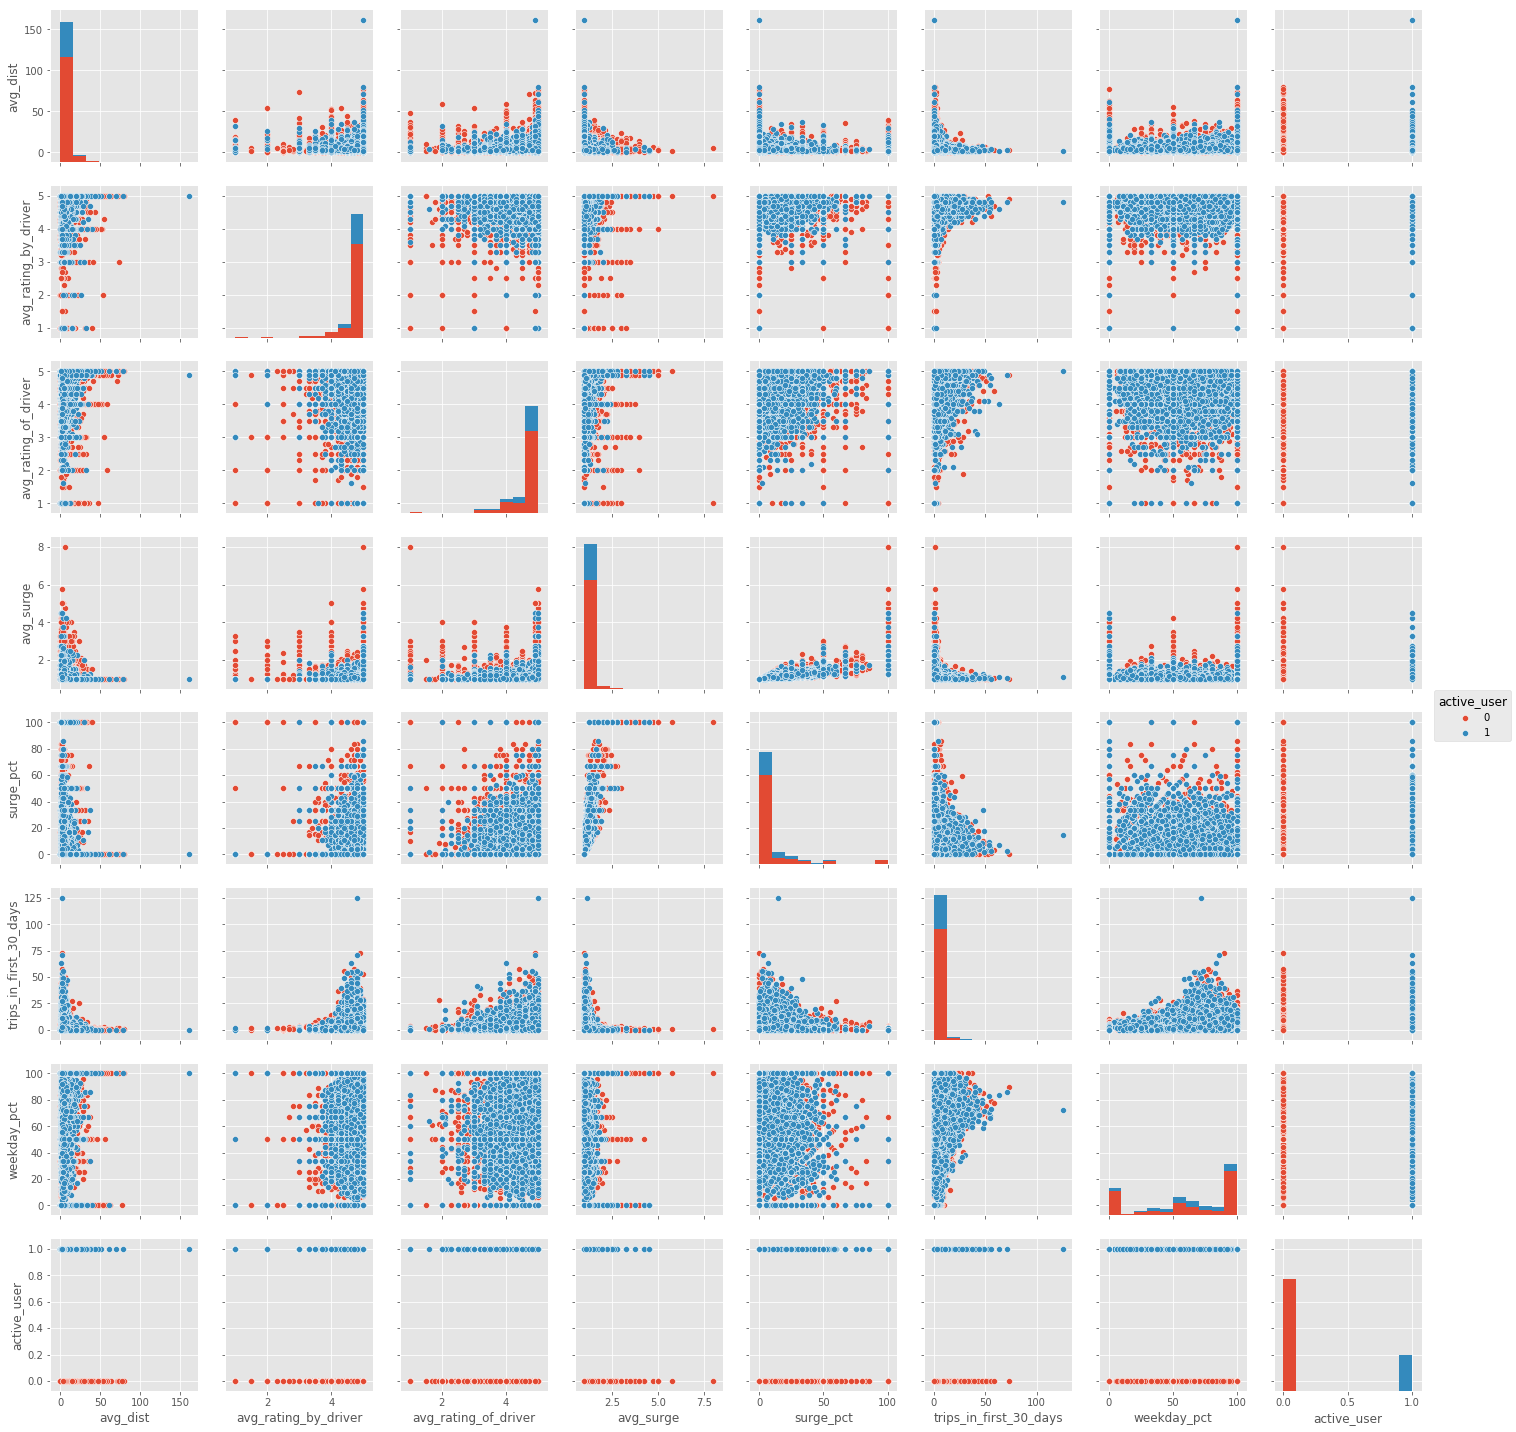

In [28]:
#
# Generate a pair plot.
#
sns.pairplot(df.select_dtypes(include =["float64","int64"]), hue='active_user')

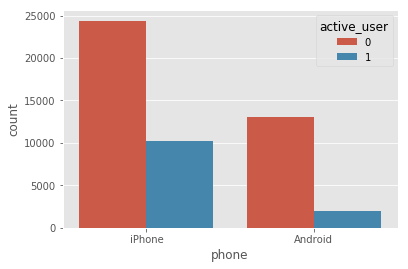

In [29]:
#
# Count by phone.
#
sns.countplot(hue="active_user", x="phone", data=df)

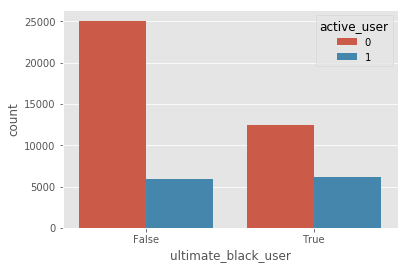

In [30]:
#
# Count by ultimate black user.
#
sns.countplot(hue="active_user", x="ultimate_black_user", data=df)

### Prepare dataframe for modeling

In [31]:
#
# Drop the time columns.
#
df.drop(["last_trip_date",'signup_date'],axis=1,inplace=True)

#
# Extract the prediction column: Active User.
#
predict = df.pop('active_user')

#
# Convert to drop android and convert black user to int.
#
df = pd.get_dummies(df,drop_first=True)
df.ultimate_black_user = df.ultimate_black_user.astype(int)

### Split into train/test.

In [32]:
#
# Split into train/test using 80/20 rule.
#
X_train, X_test, y_train, y_test = train_test_split(df, predict, test_size = 0.2, random_state=42, stratify=predict)

In [33]:
#
# Cross validate with 5 splits.
#
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#
# Model evaluation metric.
#
model_metric = make_scorer(roc_auc_score, greater_is_better=True)

### Build, tune, and fit the model

In [34]:
#
# Random Forest Classifier.
#
RF = RandomForestClassifier(n_jobs=-1)

#
# Hyperparamter grid and gridsearch. Use a full grid over all parameters.
#
param_grid = {"max_depth": [5, 10],
              "max_features": [3, 10],
              "min_samples_split": [3, 4],
              "min_samples_leaf": [5, 10],
              'n_estimators' : [45, 55],
              'class_weight' : ['balanced']
             }

#
# The grid search.
#
RF_CV = GridSearchCV(RF, param_grid, cv=CV, scoring=model_metric, verbose=1)

In [35]:
#
# Fit the model.
#
RF_CV.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [5, 10], 'max_features': [3, 10], 'min_samples_split': [3, 4], 'min_samples_leaf': [5, 10], 'n_estimators': [45, 55], 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score), verbose=1)

In [36]:
#
# Print out the best score.
#
print("Score ", RF_CV.best_score_)
print("Params ", RF_CV.best_params_)

Score  0.7432912114387733
Params  {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 45}


In [37]:
#
# Use the best parameters learned from Gridsearch in the RF Classifier.
#
RF_best = RandomForestClassifier(class_weight= RF_CV.best_params_['class_weight'], n_jobs=-1, 
                                 min_samples_split=RF_CV.best_params_['min_samples_split'], 
                                 max_depth=RF_CV.best_params_['max_depth'],
                                 n_estimators=RF_CV.best_params_['n_estimators'])

#
# Fit the model
#
RF_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            n_estimators=45, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

### Use the model for prediction

In [38]:
#
# Prediction
#
pred_prob = RF_best.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, pred_prob))
cv_score = cross_val_score(RF_best, X_test, y_test, cv=CV, scoring=model_metric)
print(cv_score)

0.8176515250675733
[0.70412371 0.73641581 0.69917869 0.72407707 0.73974454]


In [39]:
#
# What were the most important features?
#
print(pd.DataFrame(RF_best.feature_importances_, index = X_train.columns,
                   columns=['importance']).sort_values('importance', ascending=False))

                        importance
surge_pct                 0.163314
weekday_pct               0.159959
avg_rating_by_driver      0.154485
avg_surge                 0.100593
city_King's Landing       0.095273
avg_dist                  0.078322
phone_iPhone              0.074640
trips_in_first_30_days    0.065875
avg_rating_of_driver      0.050436
ultimate_black_user       0.043094
city_Winterfell           0.014008


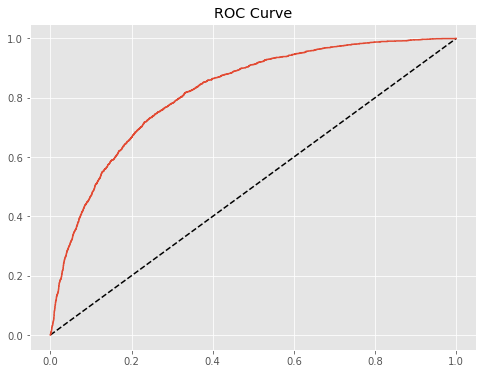

In [40]:
#
# Compute Receiver operating characteristic.
#
fpr, tpr, thresholds = roc_curve(y_test, pred_prob)

#
# Visualize the ROC Curve
#
plt.plot([0, 1], [0, 1], 'k--')
plt.gcf().set_size_inches(8,6)
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.show()

## Summary

Data was explored, cleaned, and preped for modeling. It was shown that user retention was around 24%. A Random Forest ensemble was chosen as it is generally considered a 'good' model for lots of types of problems. After determining an appropriate grid search through trial and error, the best model score was determined to be ~0.7433, which admittedly is not great, but still better than a coin flip! Using this model, Ultimate could be alerted to potential drivers than may be close to becoming inactive and take some sort of action that would need to be tested to have the best possible probability of retaining those drivers long term.